In [1]:
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Conv2DTranspose, concatenate, Multiply, Add, Activation

In [2]:
img_shape = (128,128)
image_dir = 'dataset\Food'
mask_dir = 'dataset\Segmentation'

image_paths = [os.path.join(image_dir, f) for f in sorted(os.listdir(image_dir))]
mask_paths = [os.path.join(mask_dir, f) for f in sorted(os.listdir(mask_dir))]


In [3]:

class_color = {
    'plate': '#9848ff',
    'rice': '#e7191f',
    'others': '#ffffff',
    'holud tarkari': '#14ae5c',
    'green vegetable': '#ffa629',
    'birani': '#24fda8',
    'khichuri': '#d702a8',
    'dail': '#0d99ff'
}

# Convert hex colors to RGB tuples
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# Mapping class names to RGB values
class_colors = {key: hex_to_rgb(value) for key, value in class_color.items()}

# Load and preprocess input images
def load_images(image_paths, target_size=img_shape):
    images = []
    for path in tqdm(image_paths, desc="Loading images"):
        file = tf.io.read_file(path)
        image = tf.image.decode_png(file, channels=3)
        image = tf.image.resize(image, target_size)
        images.append(image.numpy())
    return np.array(images, dtype=np.uint8)

# Load and preprocess masks (segmentation masks)
def load_masks(mask_paths, target_size=img_shape):
    masks = []
    for path in tqdm(mask_paths, desc="Loading masks"):
        file = tf.io.read_file(path)
        mask = tf.image.decode_png(file, channels=3)
        mask = tf.image.resize(mask, target_size, method='nearest')  # nearest to preserve color labels
        masks.append(mask.numpy())
    return np.array(masks, dtype=np.uint8)

def rgb_to_2D_label(label, tolerance=10):
    label_seg = np.zeros(label.shape[:2], dtype=np.uint8)
    for idx, color in enumerate(class_colors.values()):
        matches = np.all(np.abs(label - color) <= tolerance, axis=-1)
        label_seg[matches] = idx

    return label_seg


images = load_images(image_paths)
masks = load_masks(mask_paths)


Loading masks: 100%|██████████| 109/109 [00:01<00:00, 60.17it/s]


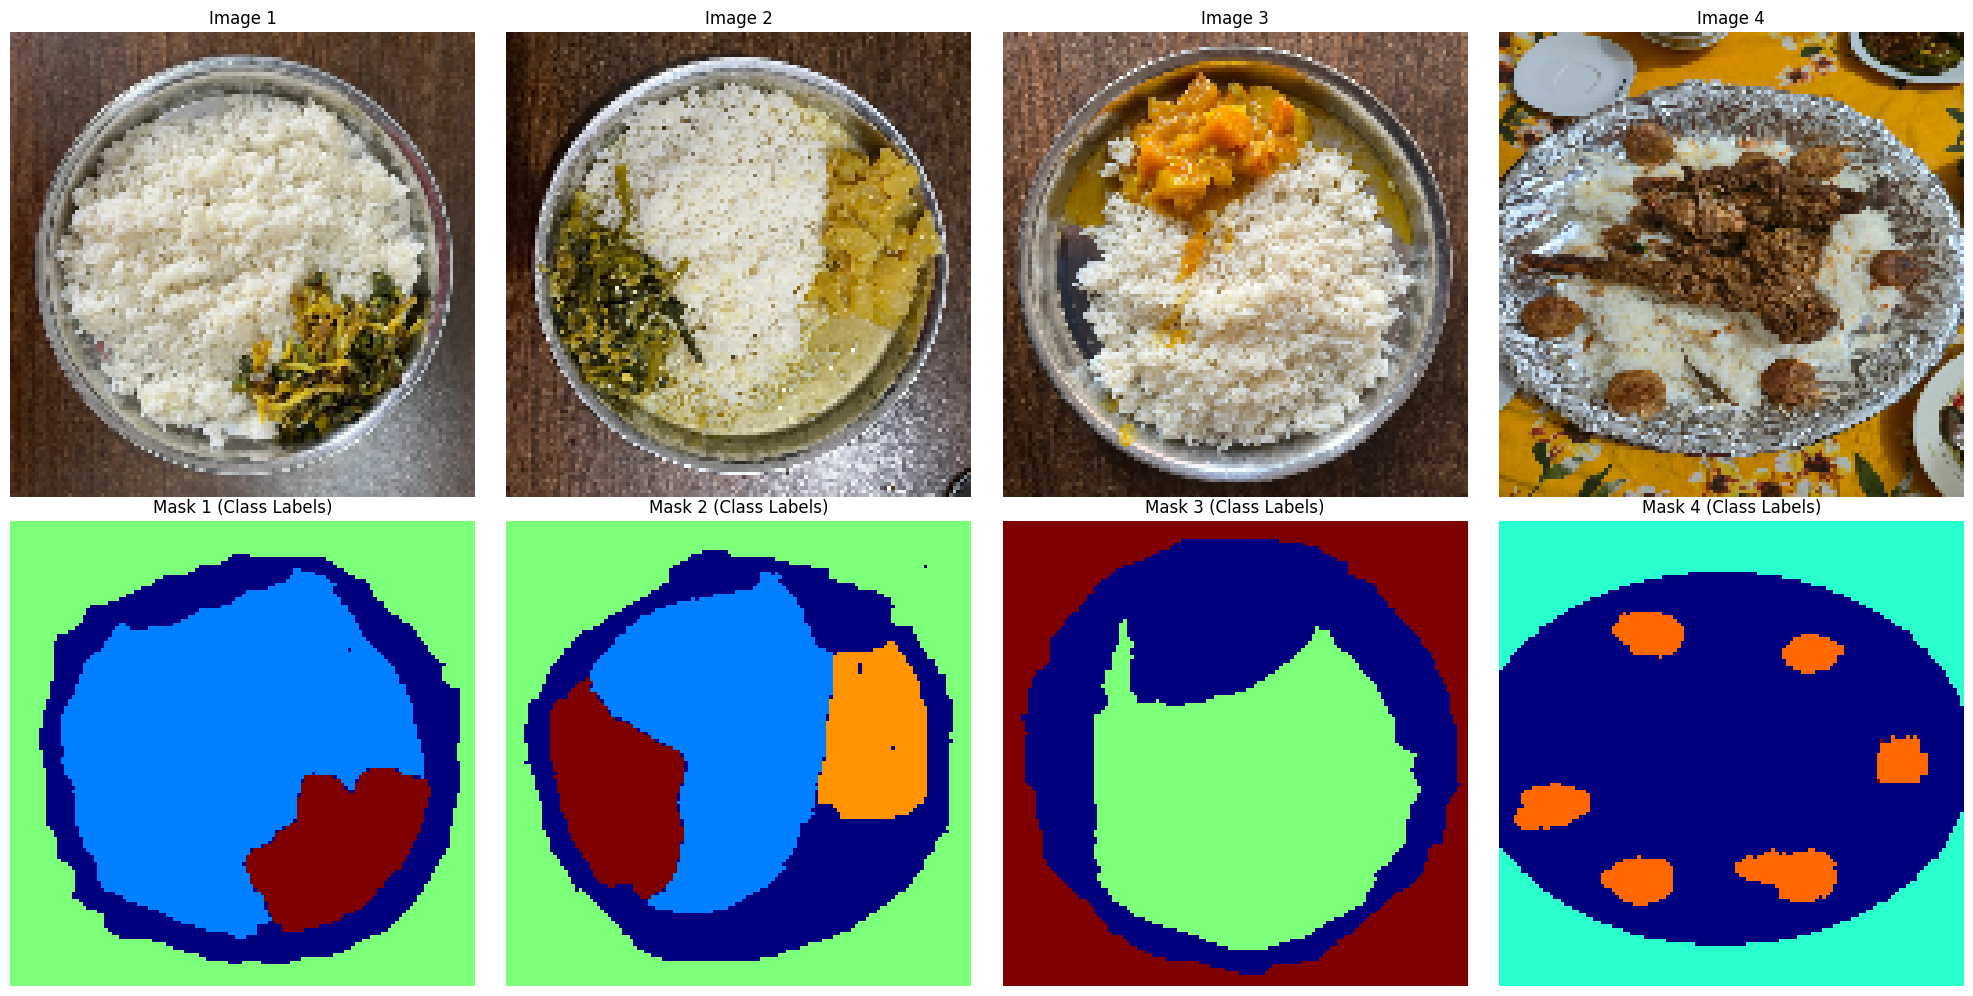

In [4]:
plt.figure(figsize=(20, 10))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f"Image {i+1}")
    plt.axis('off')

    plt.subplot(2, 4, i + 5)
    label_mask = rgb_to_2D_label(masks[i])
    plt.imshow(label_mask, cmap='jet', interpolation='nearest')
    plt.title(f"Mask {i+1} (Class Labels)")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:



# Convert masks to labels
labels = np.array([rgb_to_2D_label(mask) for mask in masks])
labels = np.expand_dims(labels, axis=3)  # Add channel dimension

# Normalize images
scaler = MinMaxScaler()
images_norm = scaler.fit_transform(images.reshape(-1, 3)).reshape(images.shape)

# One-hot encode labels
num_classes = len(class_color)
labels_categ = to_categorical(labels, num_classes=num_classes)

# Split data
X_train, X_test, y_train, y_test = train_test_split(images_norm, labels_categ, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Validation data: {X_val.shape}, {y_val.shape}")
print(f"Test data: {X_test.shape}, {y_test.shape}")

# Data augmentation
data_gen_args = dict(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Generator function
def create_generator(image_generator, mask_generator, X, y, batch_size, seed):
    image_generator = image_generator.flow(X, batch_size=batch_size, seed=seed)
    mask_generator = mask_generator.flow(y, batch_size=batch_size, seed=seed)
    while True:
        X_batch = next(image_generator)
        y_batch = next(mask_generator)
        yield X_batch, y_batch

# Create generators
batch_size = 32
seed = 42
train_generator = create_generator(image_datagen, mask_datagen, X_train, y_train, batch_size, seed)
val_generator = create_generator(ImageDataGenerator(), ImageDataGenerator(), X_val, y_val, batch_size, seed)


Training data: (87, 128, 128, 3), (87, 128, 128, 8)
Validation data: (11, 128, 128, 3), (11, 128, 128, 8)
Test data: (11, 128, 128, 3), (11, 128, 128, 8)


In [6]:


def attention_gate(F_g, F_l, inter_channels):
    W_g = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(F_g)
    W_g = BatchNormalization()(W_g)

    W_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(F_l)
    W_x = BatchNormalization()(W_x)

    psi = ReLU()(Add()([W_g, W_x]))
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(psi)
    psi = Activation('sigmoid')(psi)

    return Multiply()([F_l, psi])
def unet(n_classes=len(class_color), IMG_HEIGHT=img_shape[1], IMG_WIDTH=img_shape[0], IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Encoder
    c0 = Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    c0 = BatchNormalization()(c0)
    c0 = ReLU()(c0)
    c0 = Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal')(c0)  # added
    c0 = BatchNormalization()(c0)
    c0 = ReLU()(c0)
    p0 = MaxPooling2D((2, 2))(c0)

    c1 = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(p0)
    c1 = BatchNormalization()(c1)
    c1 = ReLU()(c1)
    c1 = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(c1)  # added
    c1 = BatchNormalization()(c1)
    c1 = ReLU()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(p1)
    c2 = BatchNormalization()(c2)
    c2 = ReLU()(c2)
    c2 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(c2)  # added
    c2 = BatchNormalization()(c2)
    c2 = ReLU()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(p2)
    c3 = BatchNormalization()(c3)
    c3 = ReLU()(c3)
    c3 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(c3)  # added
    c3 = BatchNormalization()(c3)
    c3 = ReLU()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # New deeper layer (added)
    c4 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(p3)
    c4 = BatchNormalization()(c4)
    c4 = ReLU()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck (moved to deeper level)
    c5 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(p4)
    c5 = BatchNormalization()(c5)
    c5 = ReLU()(c5)

    # Decoder with attention gates (mirrored)
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    att6 = attention_gate(u6, c4, inter_channels=128)
    u6 = concatenate([u6, att6])
    c6 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(u6)
    c6 = BatchNormalization()(c6)
    c6 = ReLU()(c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    att7 = attention_gate(u7, c3, inter_channels=64)
    u7 = concatenate([u7, att7])
    c7 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(u7)
    c7 = BatchNormalization()(c7)
    c7 = ReLU()(c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    att8 = attention_gate(u8, c2, inter_channels=32)
    u8 = concatenate([u8, att8])
    c8 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(u8)
    c8 = BatchNormalization()(c8)
    c8 = ReLU()(c8)

    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    att9 = attention_gate(u9, c1, inter_channels=16)
    u9 = concatenate([u9, att9])
    c9 = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(u9)
    c9 = BatchNormalization()(c9)
    c9 = ReLU()(c9)

    u10 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c9)
    att10 = attention_gate(u10, c0, inter_channels=8)
    u10 = concatenate([u10, att10])
    c10 = Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal')(u10)
    c10 = BatchNormalization()(c10)
    c10 = ReLU()(c10)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c10)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

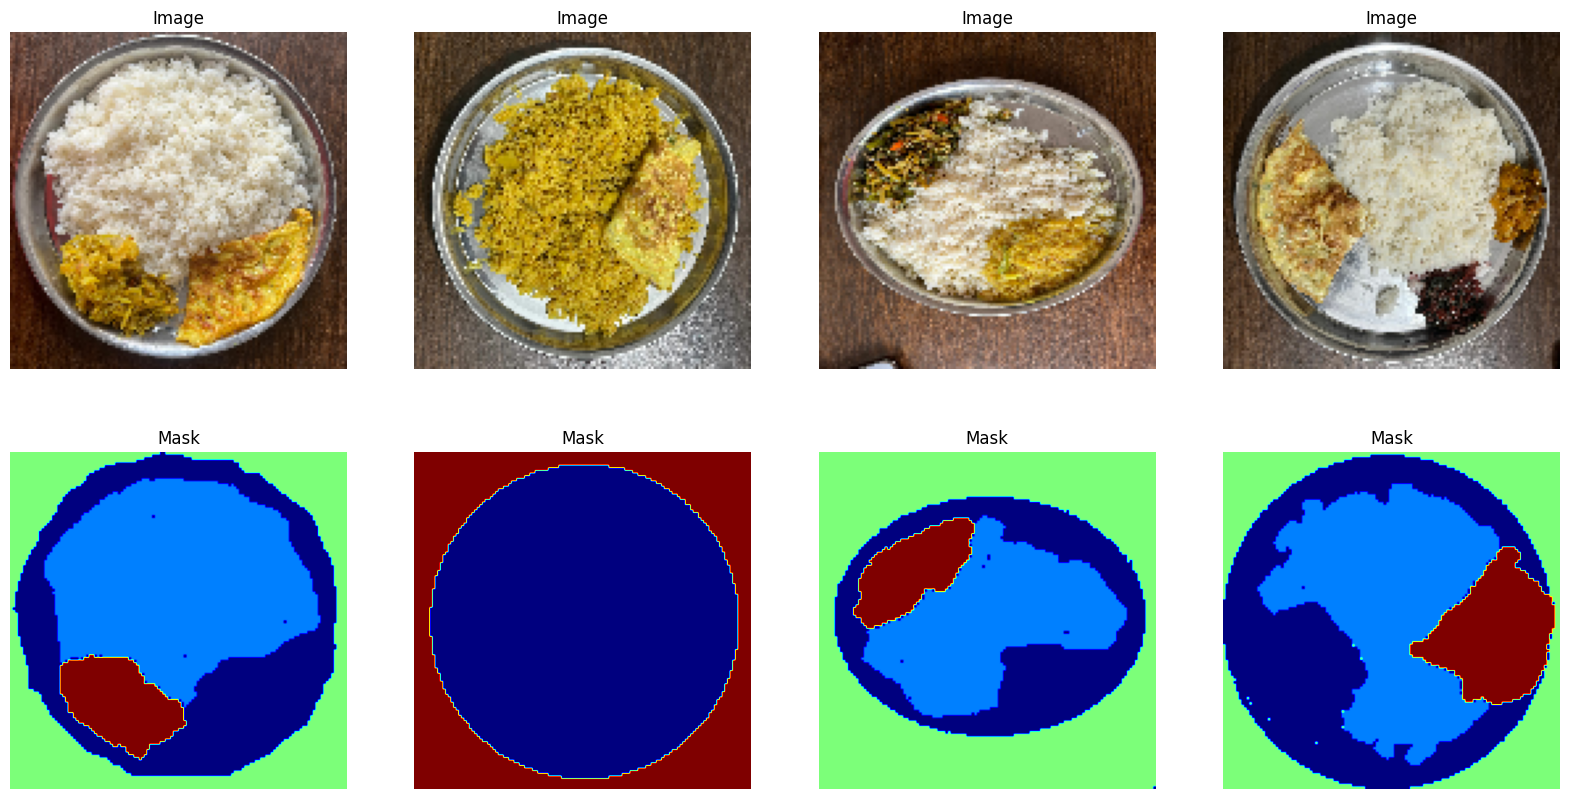

In [7]:
plt.figure(figsize=(20, 10))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_train[i])
    plt.title("Image")
    plt.axis('off')

    plt.subplot(2, 4, i + 5)
    plt.imshow(np.argmax(y_train[i], axis=-1), cmap='jet')
    plt.title("Mask")
    plt.axis('off')

In [8]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 
                      tf.keras.metrics.MeanIoU(num_classes=num_classes, name='iou')])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=0.001
)


In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=max(1, len(X_train) // batch_size),
    validation_data=val_generator,
    validation_steps=max(1, len(X_val) // batch_size),
    epochs=300,
    #callbacks=[early_stopping],
    verbose=1
)

C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\keras\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (87, 128, 128, 8) (8 channels).
  warnings.warn(


Epoch 1/300
2/2 [==============================] - ETA: 0s - loss: 2.1718 - accuracy: 0.1643 - iou: 0.4412 

C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\keras\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (11, 128, 128, 8) (8 channels).
  warnings.warn(


2/2 [==============================] - 14s 2s/step - loss: 2.1718 - accuracy: 0.1643 - iou: 0.4412 - val_loss: 2.1112 - val_accuracy: 0.0759 - val_iou: 0.4375
Epoch 2/300
2/2 [==============================] - 4s 234ms/step - loss: 1.9991 - accuracy: 0.2362 - iou: 0.4409 - val_loss: 2.0990 - val_accuracy: 0.0699 - val_iou: 0.4375
Epoch 3/300
2/2 [==============================] - 1s 348ms/step - loss: 1.9182 - accuracy: 0.2995 - iou: 0.4413 - val_loss: 2.0843 - val_accuracy: 0.1102 - val_iou: 0.4375
Epoch 4/300
2/2 [==============================] - 1s 419ms/step - loss: 1.8020 - accuracy: 0.3552 - iou: 0.4410 - val_loss: 2.0599 - val_accuracy: 0.1466 - val_iou: 0.4375
Epoch 5/300
2/2 [==============================] - 1s 513ms/step - loss: 1.6746 - accuracy: 0.3932 - iou: 0.4410 - val_loss: 2.0445 - val_accuracy: 0.2035 - val_iou: 0.4375
Epoch 6/300
2/2 [==============================] - 1s 320ms/step - loss: 1.6889 - accuracy: 0.4114 - iou: 0.4411 - val_loss: 1.9331 - val_accuracy: 0

In [10]:

test_generator = create_generator(
    ImageDataGenerator(),
    ImageDataGenerator(),
    X_test,
    y_test,
    batch_size,
    seed
)

test_steps = max(1, len(X_test) // batch_size)
test_metrics = model.evaluate(test_generator, steps=test_steps, verbose=1)


1/1 [==============================] - 0s 88ms/step - loss: 0.6754 - accuracy: 0.7828 - iou: 0.4375


In [11]:
print("\nTest Results:")
print(f"Loss: {test_metrics[0]:.4f}")
print(f"Accuracy: {test_metrics[1]:.4f}")
print(f"IoU: {test_metrics[2]:.4f}")
def visualize_predictions(model, generator, num_samples=3):
    batch = next(generator)
    X_batch, y_batch = batch[0], batch[1]
    y_pred = model.predict(X_batch)
    
    y_true_labels = np.argmax(y_batch, axis=-1)
    y_pred_labels = np.argmax(y_pred, axis=-1)
    
    def label_to_rgb(label_matrix):
        rgb = np.zeros((*label_matrix.shape, 3), dtype=np.uint8)
        for class_idx, color in enumerate(class_colors.values()):
            rgb[label_matrix == class_idx] = color
        return rgb
    
    y_true_rgb = np.array([label_to_rgb(mask) for mask in y_true_labels])
    y_pred_rgb = np.array([label_to_rgb(mask) for mask in y_pred_labels])
    
    class_names = list(class_color.keys())
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(min(num_samples, len(X_batch))):
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X_batch[i])
        plt.title("Original Image")
        plt.axis('off')
        
        # True Mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y_true_rgb[i])
        plt.title("Ground Truth")
        plt.axis('off')
        
        # Predicted Mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(y_pred_rgb[i])
        plt.title("Predicted Mask")
        plt.axis('off')
    
    # Create legend
    patches = [plt.Rectangle((0,0),1,1, color=tuple(np.array(hex_to_rgb(color))/255)) 
               for color in class_color.values()]
    plt.legend(patches, class_names, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()




Test Results:
Loss: 0.6754
Accuracy: 0.7828
IoU: 0.4375


1/1 [==============================] - 1s 827ms/step


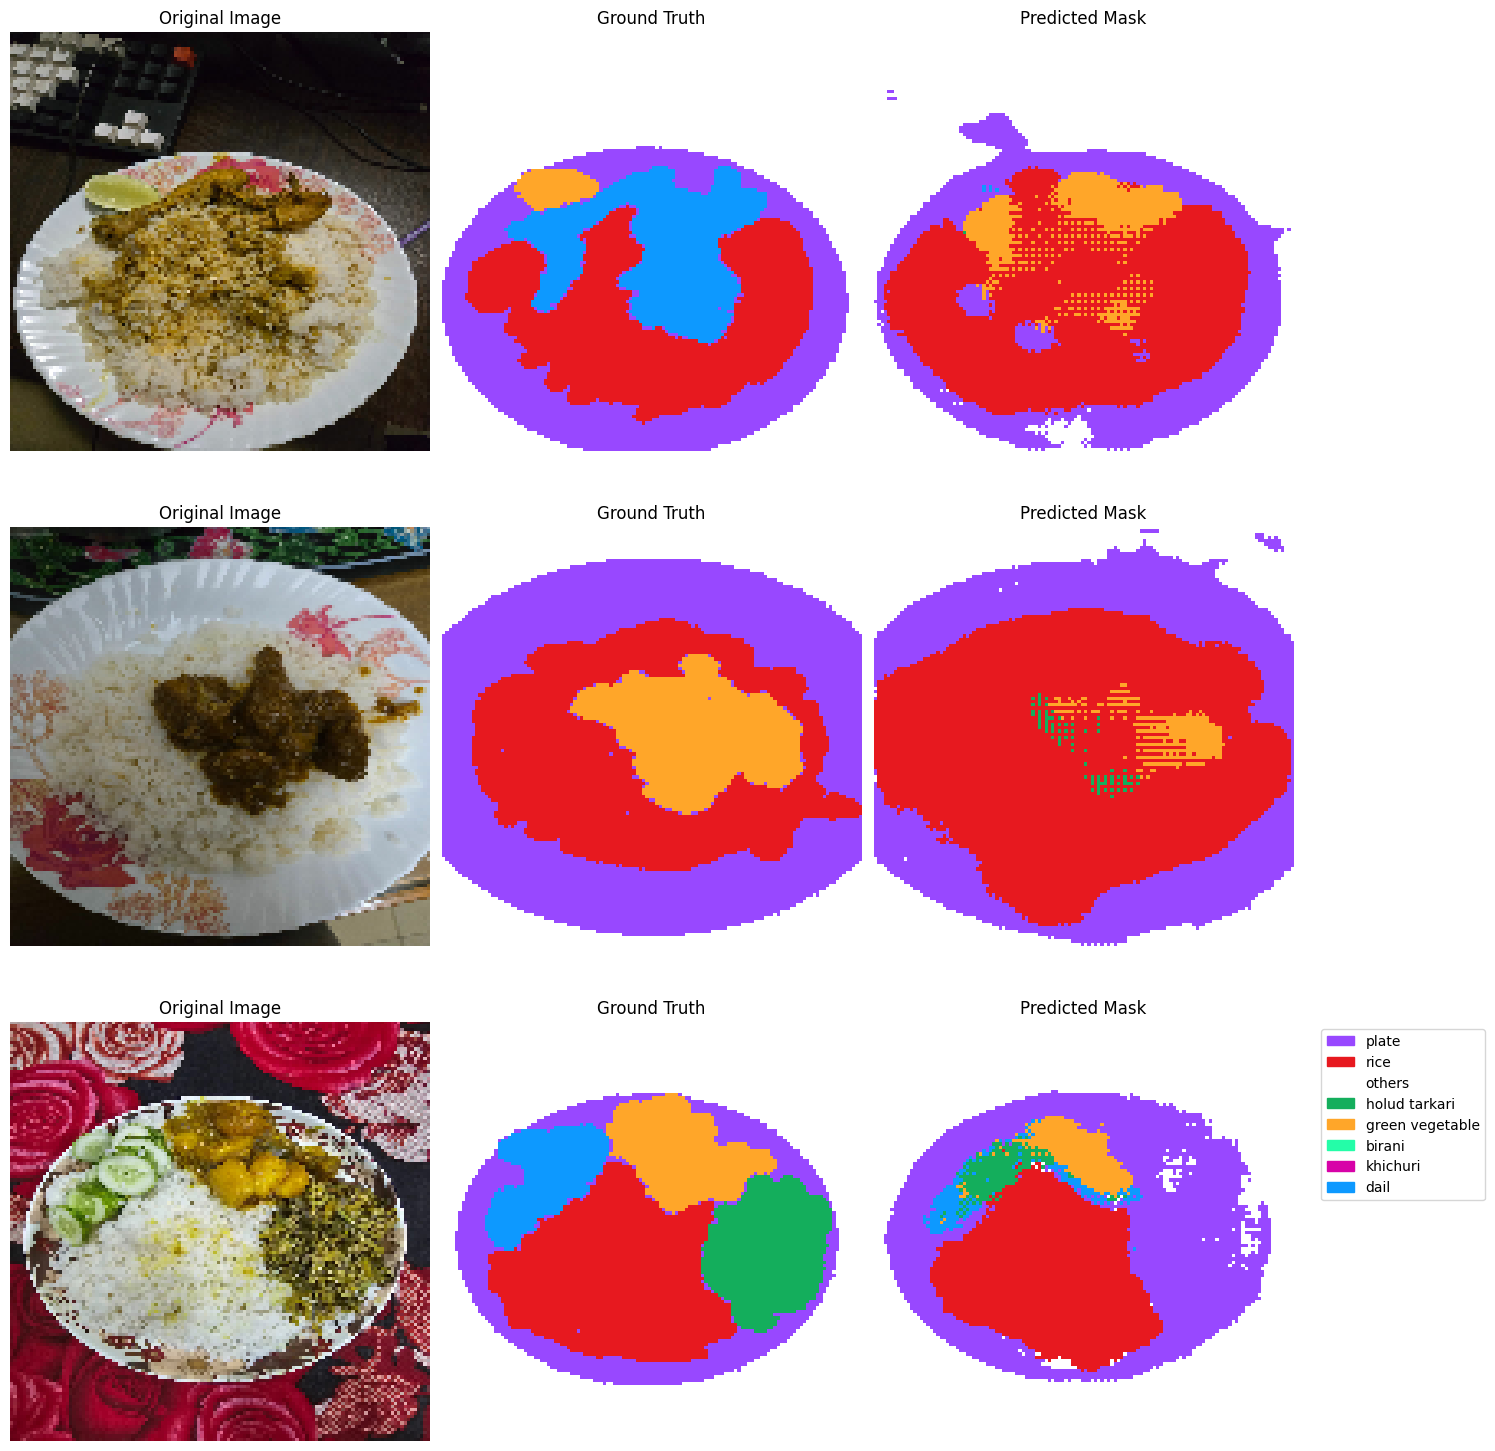

In [12]:
visualize_predictions(model, test_generator)

In [13]:
# Store losses and metrics after training
all_metrics = history.history

# Example: extract specific ones if needed
train_loss = all_metrics['loss']
val_loss = all_metrics['val_loss']
train_accuracy = all_metrics['accuracy']
val_accuracy = all_metrics['val_accuracy']
train_iou = all_metrics['iou']
val_iou = all_metrics['val_iou']


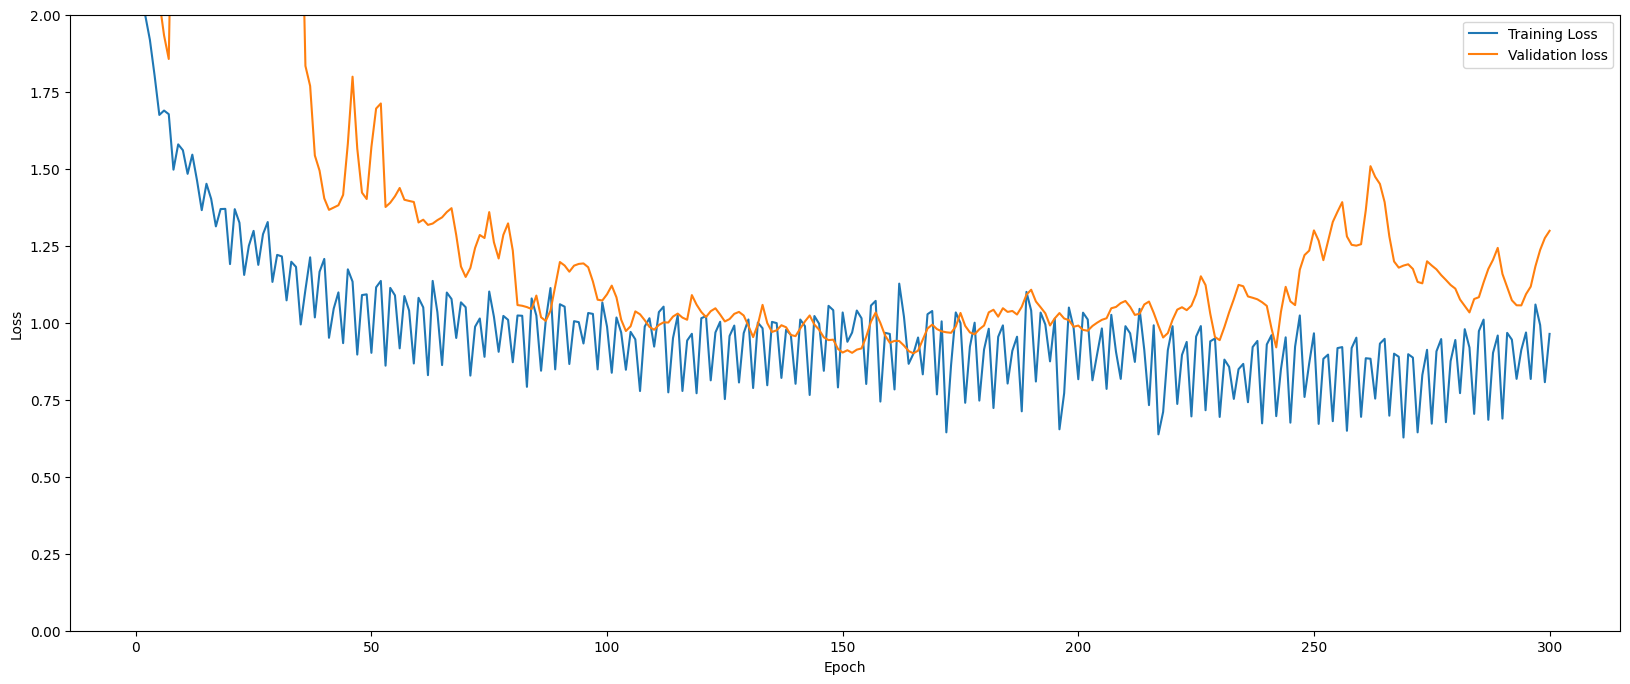

In [14]:
epoch = range(1, len(val_accuracy)+1)
plt.figure(figsize=(20,8))
plt.plot(epoch, train_loss, label='Training Loss')
plt.plot(epoch, val_loss, label= 'Validation loss')
plt.ylim(0,10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,2)
plt.legend()
plt.show()

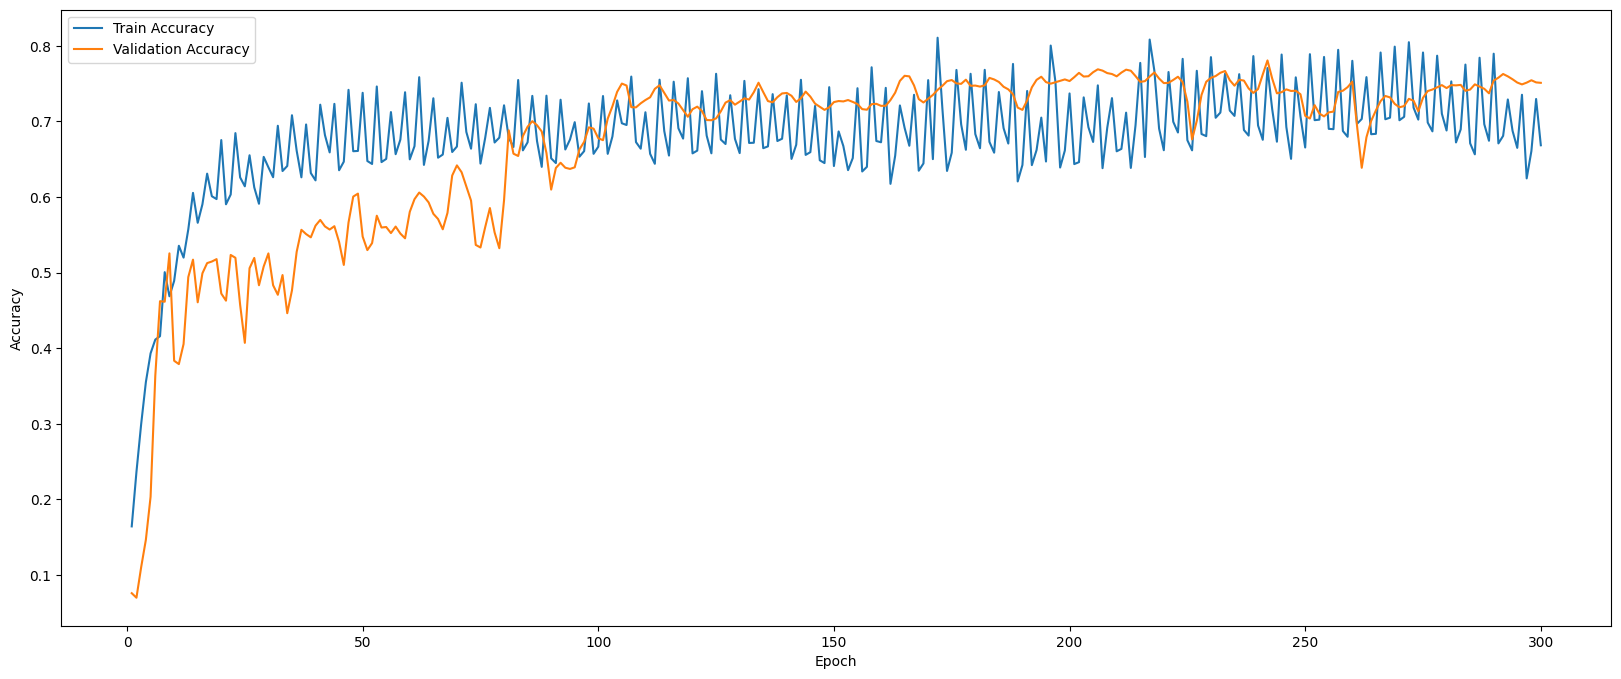

In [15]:
epoch = range(1, len(val_accuracy)+1)
plt.figure(figsize=(20,8))
plt.plot(epoch, train_accuracy, label='Train Accuracy')
plt.plot(epoch, val_accuracy, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [16]:
max_val= max(max(train_iou), max(val_iou)) 
min_val= min(min(train_iou), min(val_iou))
max_val= max_val+(max_val*0.01)
min_val= min_val-(min_val*0.01)

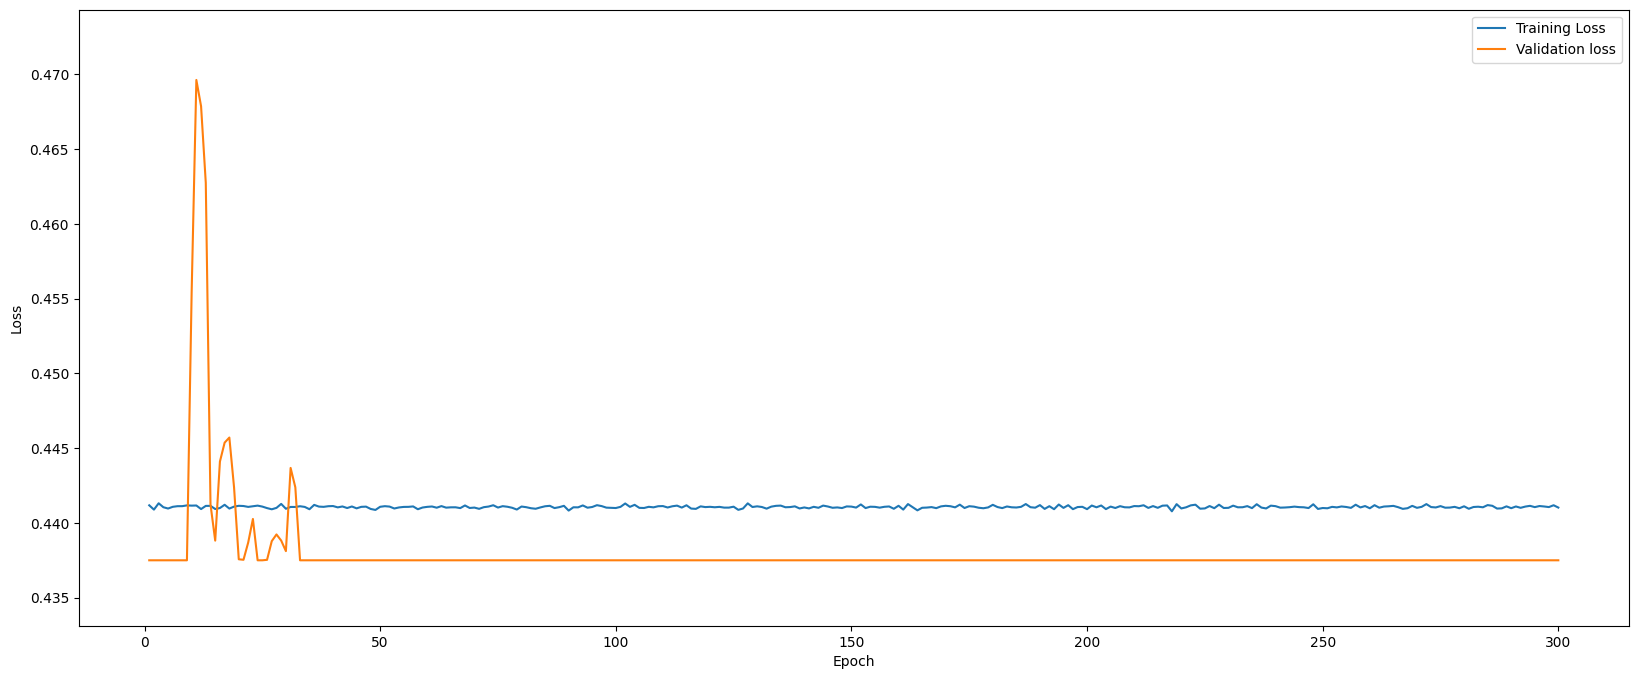

In [17]:
epoch = range(1, len(val_accuracy)+1)
plt.figure(figsize=(20,8))
plt.plot(epoch, train_iou, label='Training Loss')
plt.plot(epoch, val_iou, label= 'Validation loss')
plt.ylim(min_val,max_val)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()